In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern,WhiteKernel, ConstantKernel as C
import warnings
warnings.filterwarnings('ignore')

from utils import plot_GMM


Using LASA DataSet from /home/oem/v_torch/lib/python3.8/site-packages/pyLasaDataset/resources/LASAHandwritingDataset/DataSet


In [2]:
from utils import load_lasa
def load(   shape='DoubleBendedLine'):

    X, Y = load_lasa(shape)
    return X, Y

In [3]:
def var_gradient( x, X, K_inv, kernel, kernel_params_): # GP with RBF kernel 
    """Input has shape n_query x n_features. 
    Output is the  derivative of the predicted variance 
    Each utput has shape n_query x n_features x n_outputs.
    The output in position i,j,k has the derivative respect to the j-th feature of the k-th output, in position of the i-th data point.
    For the derivative of sigma n_outputs is equal to 1"""
    lscale=  kernel_params_[0].reshape(-1,1)
    n_samples, n_features= np.shape(X)
    lscale_stack= np.hstack([lscale]*  n_samples)
    dsigma_dx=[]
    for i in range(np.shape(x)[0]):
        k_star=   kernel( X, x[i,:].reshape(1,-1))
        k_star_T=k_star.transpose()
        k_star_stack= np.vstack([k_star_T]*  n_features)
        beta = -2 * np.matmul( K_inv, k_star)
        dk_star_dX= k_star_stack * (  X- x[i,:]).transpose()/ (lscale_stack** 2)
        dsigma_dx.append(np.matmul(dk_star_dX, beta))
    return np.array(dsigma_dx)
    
def global_attractor(X,X_goal):
    Y=(X_goal-X)
    Y_norm=np.clip((np.sqrt(Y[0]**2+Y[1]**2)),0,1)
    #print(Y)
    if (np.sqrt(Y[0]**2+Y[1]**2))>0.0000001:
        Y=Y_norm*Y/(np.sqrt(Y[0]**2+Y[1]**2))
    else:
        Y=Y
    return Y 

In [9]:
X, X_dot= load('GShape')
# downsample the data
X = X[200::10]
X_dot = X_dot[200::10]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f54745760d0>
Traceback (most recent call last):
  File "/home/oem/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/oem/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/oem/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/oem/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x

Not empty components:
1
4
5
6
7
10
11


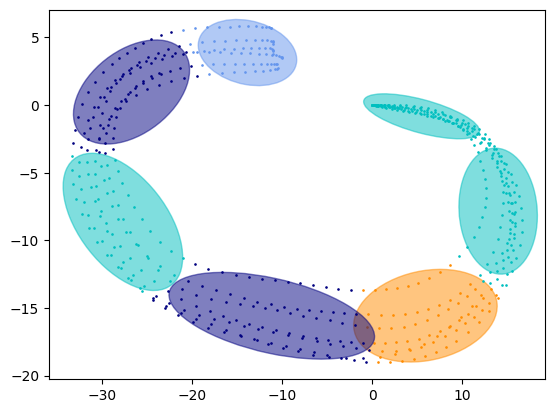

In [5]:
#create empty list for each components of the mixture
GP_=[]
IND=[]
KERNEL_PAR=[]
KERNEL=[]
KINV=[]
X_=[]

k = C(constant_value=np.sqrt(0.1))  * Matern(1*np.ones(2), nu=1.5) + WhiteKernel(0.01 )
gp = GaussianProcessRegressor(kernel=k, alpha=1e-10, n_restarts_optimizer=5)
gmm = BayesianGaussianMixture(n_components=20,weight_concentration_prior_type='dirichlet_process',weight_concentration_prior=1).fit(X)

plot_GMM(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0)

index=gmm.predict(X)
print("Not empty components:")
for i in range(gmm.n_components):
    if not np.any(index== i):
        continue
    print(i)    
    X_0=(X[index==i,:])
    
    Y_0=(X_dot[index==i,:])
    gp = GaussianProcessRegressor(kernel=k, alpha=1e-10, n_restarts_optimizer=5)
    gp.fit(X_0,Y_0)
    gp_kernels_ = gp.kernel_
    kernel_params_ = [gp_kernels_.get_params()['k1__k2__length_scale'], gp_kernels_.get_params()['k1']]
    noise_var_ = gp.alpha + gp_kernels_.get_params()['k2__noise_level']
    K_ = gp_kernels_(X_0, X_0) + (noise_var_ * np.eye(len(X_0)))
    K_inv = np.linalg.inv(K_)
    KERNEL.append(gp_kernels_)
    KINV.append(K_inv)
    KERNEL_PAR.append(kernel_params_)
    GP_.append(gp)
    X_.append(X_0)
    IND.append(i)
x=np.linspace(np.min(X[:,0]-10), np.max(X[:,0]+10), 100)
y=np.linspace(np.min(X[:,1]-10), np.max(X[:,1]+10), 100)
# Creating grids
XX, YY = np.meshgrid(x, y)
u=np.ones((len(x),len(y)))
v=np.ones((len(x),len(y)))

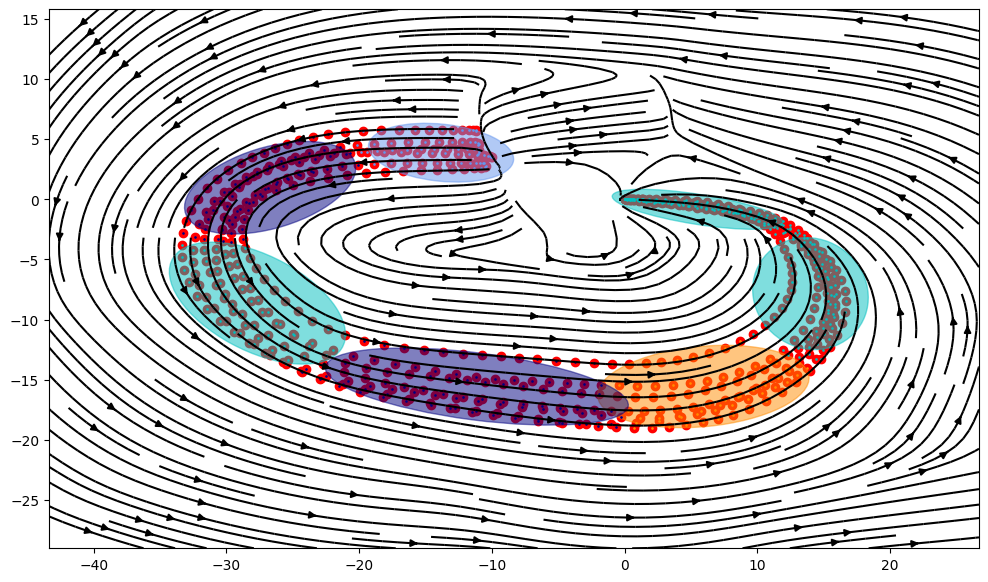

In [6]:
vel_x=np.zeros(np.shape(GP_)[0])
vel_y=np.zeros(np.shape(GP_)[0])
grad_x=np.zeros(np.shape(GP_)[0])
grad_y=np.zeros(np.shape(GP_)[0])
var_=np.zeros(np.shape(GP_)[0])
WEI=np.zeros(np.shape(GP_)[0])
x=np.linspace(np.min(X[:,0]-10), np.max(X[:,0]+10), 100)
y=np.linspace(np.min(X[:,1]-10), np.max(X[:,1]+10), 100)
# Creating grids
XX, YY = np.meshgrid(x, y)
u=np.ones((len(x),len(y)))
v=np.ones((len(x),len(y)))
pos=np.hstack([XX.reshape(-1,1), YY.reshape(-1,1)])
weights=(gmm.predict_proba(pos))

for k in range(np.shape(GP_)[0]):
    [vel, var]=GP_[k].predict(pos, return_std=True)
    grad=var_gradient( x, X_[k], KINV[k], KERNEL[k], KERNEL_PAR[k][0])
    grad_x[k]=grad[0]
    grad_y[k]=grad[1]
    vel_x[k]=vel[0][0]
    vel_y[k]=vel[0][1]
    var_[k]=var[0][0]
    WEI[k]=weights[0][IND[k]]
WEI=WEI.reshape(np.shape(GP_)[0],1)   
grad_x_avg=np.dot(grad_x.reshape(1,-1), WEI )
grad_y_avg=np.dot(grad_y.reshape(1,-1), WEI)

var_avg=np.dot(var_, WEI)
vel_x_avg=np.dot(vel_x, WEI)
vel_y_avg=np.dot(vel_y, WEI)
u[i,j]=vel_x_avg[0]
v[i,j]=vel_y_avg[0]        

        
fig = plt.figure(figsize = (12, 7))
plt.streamplot(XX, YY, u, v, density = 2, color=[0,0,0])
plt.scatter(X[:,0],X[:,1], color=[1,0,0])
plot_GMM(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0)

plt.show()

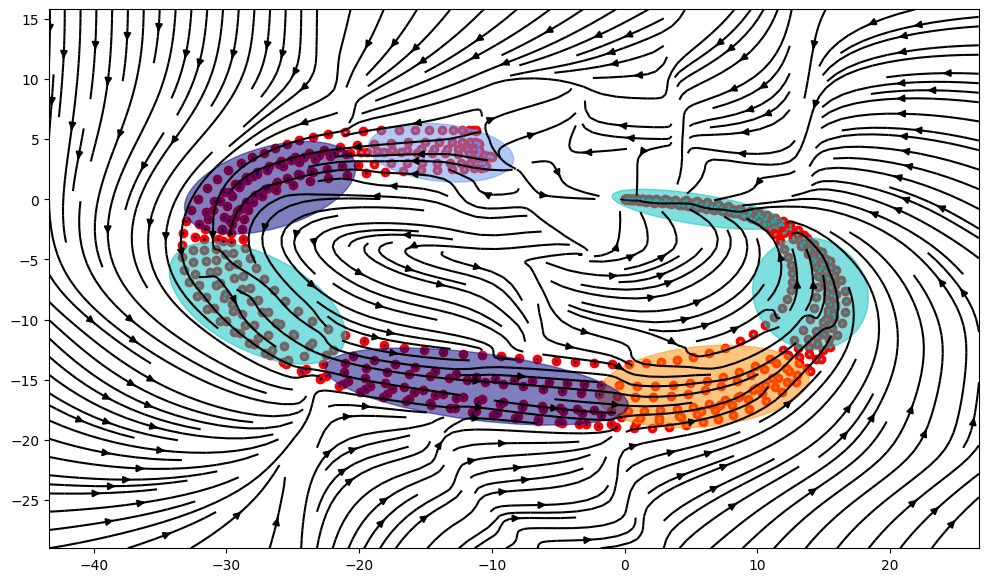

In [7]:
vel_x=np.zeros(np.shape(GP_)[0])
vel_y=np.zeros(np.shape(GP_)[0])
grad_x=np.zeros(np.shape(GP_)[0])
grad_y=np.zeros(np.shape(GP_)[0])
var_=np.zeros(np.shape(GP_)[0])
WEI=np.zeros(np.shape(GP_)[0])
x=np.linspace(np.min(X[:,0]-10), np.max(X[:,0]+10), 100)
y=np.linspace(np.min(X[:,1]-10), np.max(X[:,1]+10), 100)
# Creating grids
XX, YY = np.meshgrid(x, y)
u=np.ones((len(x),len(y)))
v=np.ones((len(x),len(y)))
for i in range(len(y)):
    for j in range(len(x)):
        pos=np.array([XX[i,j],YY[i, j]]).reshape(1,-1)
        weights=(gmm.predict_proba(pos))
        for k in range(np.shape(GP_)[0]):
            [vel, var]=GP_[k].predict(pos, return_std=True)
            grad=var_gradient(pos, KERNEL_PAR[k][0], X_[k], KERNEL[k], KINV[k] )
            grad_x[k]=grad[0]
            grad_y[k]=grad[1]
            vel_x[k]=vel[0][0]
            vel_y[k]=vel[0][1]
            var_[k]=var[0][0]
            WEI[k]=weights[0][IND[k]]
        WEI=WEI.reshape(np.shape(GP_)[0],1)   
        grad_x_avg=np.dot(grad_x.reshape(1,-1), WEI )
        grad_y_avg=np.dot(grad_y.reshape(1,-1), WEI)
        
        var_avg=np.dot(var_, WEI)
        vel_x_avg=np.dot(vel_x, WEI)
        vel_y_avg=np.dot(vel_y, WEI)
        u[i,j]=vel_x_avg[0]-var_avg[0]*(grad_x_avg/np.linalg.norm([grad_x_avg,grad_x_avg]))
        v[i,j]=vel_y_avg[0]-var_avg[0]*(grad_y_avg/np.linalg.norm([grad_x_avg,grad_x_avg]))        

        
fig = plt.figure(figsize = (12, 7))
plt.streamplot(XX, YY, u, v, density = 2, color=[0,0,0])
plt.scatter(X[:,0],X[:,1], color=[1,0,0])
plot_GMM(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0)

plt.show()

TypeError: plot_GMM() takes 5 positional arguments but 6 were given

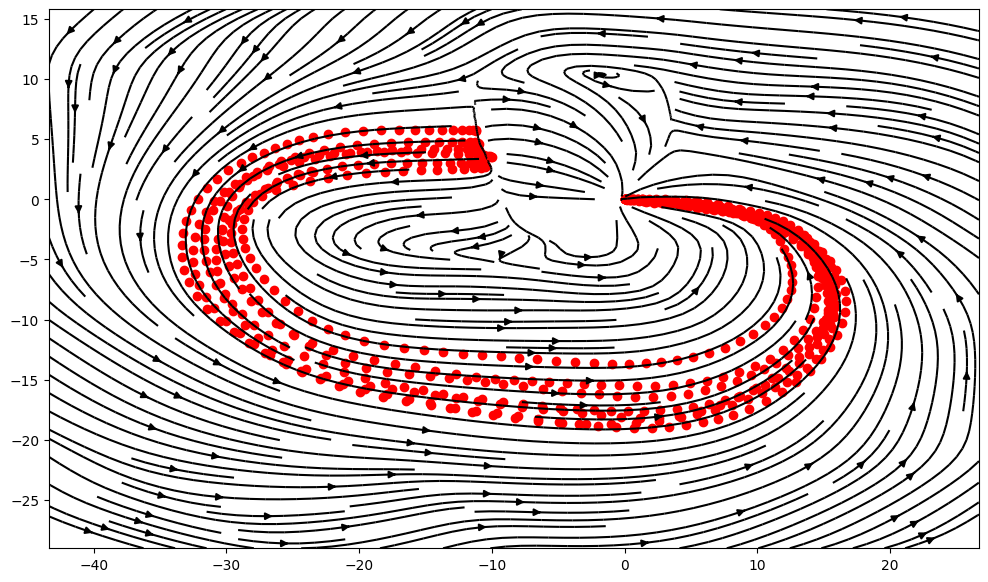

In [8]:
X_goal=X[-1,:]
vel_x=np.zeros(np.shape(GP_)[0])
vel_y=np.zeros(np.shape(GP_)[0])
grad_x=np.zeros(np.shape(GP_)[0])
grad_y=np.zeros(np.shape(GP_)[0])
var_=np.zeros(np.shape(GP_)[0])
WEI=np.zeros(np.shape(GP_)[0])
x=np.linspace(np.min(X[:,0]-10), np.max(X[:,0]+10), 100)
y=np.linspace(np.min(X[:,1]-10), np.max(X[:,1]+10), 100)
# Creating grids
XX, YY = np.meshgrid(x, y)
u=np.ones((len(x),len(y)))
v=np.ones((len(x),len(y)))
for i in range(len(y)):
    for j in range(len(x)):
        pos=np.array([XX[i,j],YY[i, j]]).reshape(1,-1)
        weights=(gmm.predict_proba(pos))
        for k in range(np.shape(GP_)[0]):
            [vel, var]=GP_[k].predict(pos, return_std=True)
            grad=global_attractor(pos[0],X_goal)
            grad_x[k]=grad[0]
            grad_y[k]=grad[1]
            vel_x[k]=vel[0][0]
            vel_y[k]=vel[0][1]
            var_[k]=var[0][0]
            WEI[k]=weights[0][IND[k]]
        WEI=WEI.reshape(np.shape(GP_)[0],1)   
        grad_x_avg=np.dot(grad_x.reshape(1,-1), WEI )
        grad_y_avg=np.dot(grad_y.reshape(1,-1), WEI)
        
        var_avg=np.dot(var_, WEI)
        vel_x_avg=np.dot(vel_x, WEI)
        vel_y_avg=np.dot(vel_y, WEI)
        u[i,j]=vel_x_avg[0]+var_avg[0]*(grad_x_avg)
        v[i,j]=vel_y_avg[0]+var_avg[0]*(grad_y_avg)        

        
fig = plt.figure(figsize = (12, 7))
plt.streamplot(XX, YY, u, v, density = 2, color=[0,0,0])
plt.scatter(X[:,0],X[:,1], color=[1,0,0])
plot_GMM(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0)

plt.show()